In [1]:
import numpy as np

class my_ueg:

    def __init__(self, rs, nelec):
        self.rs = rs
        self.nelec = nelec
        self.nparticle = sum(nelec)
        self.volume = self.nparticle * 4*np.pi/3 * rs**3
        self.length = self.volume**(1/3)

    def canonical_sign(self, npts):
        # define the sign by first non-zero element
        nz = np.argmax(npts != 0, axis=1)
        signs = np.ones(len(npts), dtype=int)
        mask = npts[np.arange(len(npts)), nz] < 0
        signs[mask] = -1

        return npts * signs[:, None]

    def get_npts(self, N_cut, with_zero=True):
        '''
        generate a 3D-spherical grid points of integers
        {(n1,n2,n3)| n1^2+n2^2+n3^2<N_cut^2; n1,n2,n3 in Z}
        sorted by incresing length and n next to -n
        '''
        n_max = int(np.ceil(N_cut))

        n = np.arange(-n_max, n_max + 1)
        nx, ny, nz = np.meshgrid(n, n, n, indexing="ij")

        n2 = nx**2 + ny**2 + nz**2
        mask = n2 <= N_cut**2 + 1e-10
        npts = np.stack((nx[mask], ny[mask], nz[mask]), axis=1)    

        can_npts = self.canonical_sign(npts)
        unq_npts = np.unique(can_npts, axis=0)
        unq_npts = unq_npts[np.argsort(np.sum(unq_npts**2, axis=1))]
        sort_npts = [[unq_npts[i],-1*unq_npts[i]] for i in range(1,len(unq_npts))]
        sort_npts = np.vstack(sort_npts)
        
        if with_zero:
            sort_npts = np.vstack([[0,0,0],sort_npts])

        return sort_npts

    def get_kpts(self, gamma=2, with_zero=True):
        '''
        get the k-points in a sphere
        by k_cut = gamma * k_fermi
        '''
        rs = self.rs
        Np = sum(self.nelec)

        Nf = (3*Np/(8*np.pi))**(1/3)
        Nc = gamma * Nf
        npts = self.get_npts(Nc, with_zero)
        
        L = (4*np.pi*Np/3)**(1/3) * rs
        kpts = npts * (2*np.pi/L)

        return kpts
    
    def madelung(self):
        '''
        Madelung term 
        interaction of each charge with its image in other cells
        '''
        rs = self.rs
        Np = sum(self.nelec)
        em = -2.837297 * (3/(4*np.pi))**(1/3) * Np**(2/3) / rs
        
        return em
    
    def get_h1(self, kpts):
        h1 = np.diag(np.sum(kpts**2, axis=1)/2)
        return h1
    
    def get_eris_hard(self, kpts):
        '''
        The naive way of calculating k-space eris 
        <k1k2|V|k3k4> = 4pi/V 1/(k1-k3)^2 delta(k1+k2,k3+k4)
        transpose to (11|22) notation
        '''
        
        Nk = len(kpts)
        eris = np.zeros((Nk, Nk, Nk, Nk), dtype=float)

        for i1, k1 in enumerate(kpts):
            for i2, k2 in enumerate(kpts):
                for i3, k3 in enumerate(kpts):
                    for i4, k4 in enumerate(kpts):
                        q = k1 - k3
                        g = k4 - k2
                        q2 = np.dot(q, q)
                        if q2 < 1e-10:
                            continue
                        consv = np.linalg.norm(g-q) < 1e-12
                        if not consv:
                            continue

                        eris[i1, i2, i3, i4] = 4*np.pi / q2 / self.volume
        
        return eris.transpose(0,2,1,3)


In [2]:
mu = my_ueg(rs=1,nelec=(5,5))

In [305]:
kpts = mu.get_kpts(1.5)
# print(npts.shape)
# print(npts)
print(np.sum(kpts**2, axis=1)/2)
h1 = np.diag(np.sum(kpts**2, axis=1)/2)
print(h1)

[0.         1.63658036 1.63658036 1.63658036 1.63658036 1.63658036
 1.63658036 3.27316072 3.27316072 3.27316072 3.27316072 3.27316072
 3.27316072 3.27316072 3.27316072 3.27316072 3.27316072 3.27316072
 3.27316072]
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         1.63658036 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.63658036 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.63658036 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.        ]
 [0.      

In [21]:
ns = mu.get_npts(N_cut=1.5, with_zero=True)
n_max = (np.sqrt(np.sum(ns**2, axis=1))).max()
print(n_max,len(ns))

1.4142135623730951 19


In [5]:
n_list = np.arange(1,4,0.01)
print(len(n_list))

300


In [9]:
n_list = np.arange(1,3,0.001)
len_list = np.empty(len(n_list))
for i,n in enumerate(n_list):
    mu = my_ueg(rs=1, nelec=(5,5))
    ns = mu.get_npts(N_cut=n, with_zero=True)
    n_max = (np.sqrt(np.sum(ns**2, axis=1))).max()
    len_list[i] = len(ns)
    # n_list[i] = n_max
    if len_list[i] > len_list[i-1]:
        print(len_list[i-1],len_list[i],n_list[i-1],n_list[i])

8.4879831673e-314 7.0 2.99899999999978 1.0
7.0 19.0 1.4139999999999544 1.4149999999999543
19.0 27.0 1.7319999999999194 1.7329999999999193
27.0 33.0 1.99899999999989 1.9999999999998899
33.0 57.0 2.235999999999864 2.2369999999998638
57.0 81.0 2.4489999999998404 2.4499999999998403
81.0 93.0 2.8279999999997987 2.8289999999997986


In [10]:
3**3*4/3*np.pi

113.09733552923255

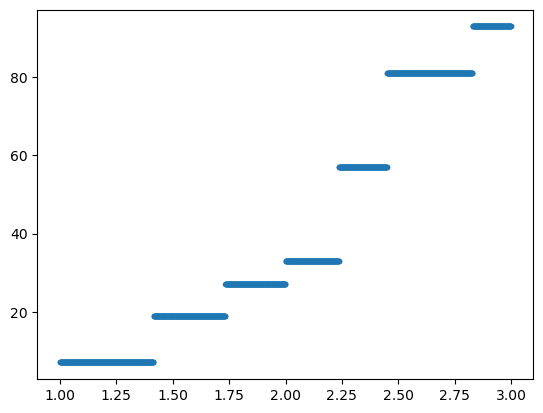

In [11]:
import matplotlib.pyplot as plt
plt.plot(n_list,len_list,'.')
# plt.plot(n_list,[0]*len(n_list),'--')
plt.show()

In [5]:
n_list = np.arange(6,200,2)
k_list = np.empty(n_list.shape)
for i,n in enumerate(n_list):
    mu = my_ueg(rs=1, nelec=(n//2,n//2))
    ks = mu.get_kpts(gamma=1.414, with_zero=True)
    k_abs = np.sqrt(np.sum(ks**2, axis=1))
    k_list[i] = k_abs[n//2-1]

K Fermi:  1.9191582926775128


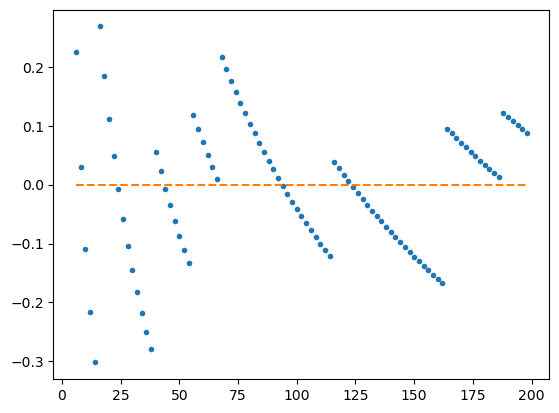

In [6]:
# True Fermi level for rs=1 vs. Fermi level by filling up discrete k-space
import matplotlib.pyplot as plt

kf = (9*np.pi/4)**(1/3)
print('K Fermi: ', kf)

plt.plot(n_list,k_list-kf,'.')
plt.plot(n_list,[0]*len(n_list),'--')
plt.show()

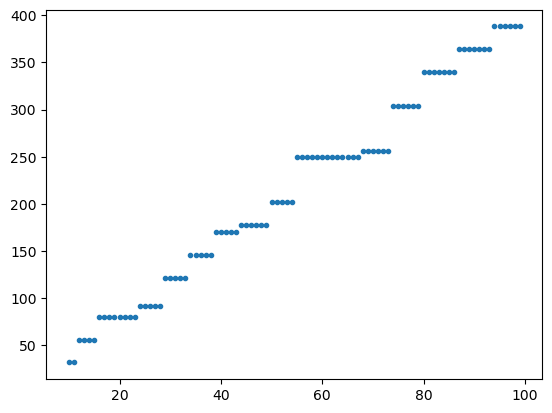

In [ ]:
# use gamma=2, get about 2^3/2 = 4x (restricted) the num of states vs. particles
n_list = np.arange(10,100)
ns = np.empty(n_list.shape)
for i,n in enumerate(n_list):
    ns[i] = get_kpts(rs=1, Np=n, gamma=2).shape[0]
    if ns[i] < n/2:
        print(ns[i], n)

plt.plot(n_list,ns,'.')
plt.show()

81


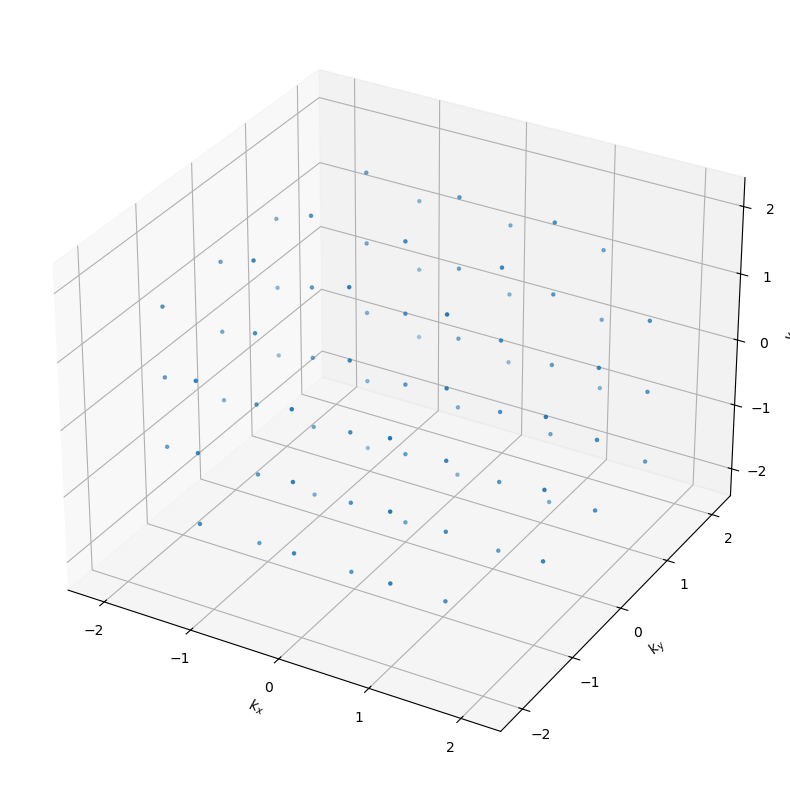

In [254]:
import matplotlib.pyplot as plt

k_sphere = get_kpts(rs=1, Np=50, gamma=1.5, with_zero=True)
print(k_sphere.shape[0])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')

ax.scatter(k_sphere[:,0], k_sphere[:,1], k_sphere[:,2], s=5)

ax.set_xlabel(r'$k_x$')
ax.set_ylabel(r'$k_y$')
ax.set_zlabel(r'$k_z$')

plt.show()